In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dl_portfolio.data import load_data
from dl_portfolio.backtest import (
    backtest_stats,
)
import pickle
import os
import seaborn as sns

# Some useful functions

In [2]:
def load_all_backtest_result(ae_dir, dataset, hedge=0):
    # Load Market budget
    if dataset == 'dataset1':
        market_budget = pd.read_csv('data/dataset1/market_budget_dataset1.csv', index_col=0)
        cryptos = ['BTC', 'DASH', 'ETH', 'LTC', 'XRP']
        market_budget = pd.concat([market_budget, pd.DataFrame(np.array([['crypto', 1]] * len(cryptos)),
                                                               index=cryptos,
                                                               columns=market_budget.columns)])
        # market_budget = market_budget.drop('CRIX')
        market_budget['rc'] = market_budget['rc'].astype(int)
    elif dataset == 'dataset2':
        market_budget = pd.read_csv('data/dataset2/market_budget_dataset2.csv', index_col=0)
        market_budget['rc'] = market_budget['rc'].astype(int)
    else:
        raise NotImplementedError()
            
    port_weights = pickle.load(open(f'{ae_dir}/portfolios_weights.p', 'rb'))
    hedge_port_weights = pickle.load(open(f'{ae_dir}/portfolios_weights_hedged_{hedge}.p', 'rb')) 
    
    for k in hedge_port_weights:
        port_weights[k + "_hedge"] = hedge_port_weights[k]
        
    ann_perf = pd.read_csv(f'{ae_dir}/portfolios_returns.csv', index_col = 0, parse_dates=True)
    
    hedged_perf = pd.read_csv(f'{ae_dir}/portfolios_returns_hedged_{hedge}.csv', index_col = 0)
    hedged_perf.index = pd.to_datetime(hedged_perf.index)
    hedged_perf.columns = [c +"_hedge" for c in hedged_perf.columns]
    ann_perf = pd.concat([ann_perf, hedged_perf], axis = 1)
    
    ann_perf = ann_perf.loc[:, ~ann_perf.columns.duplicated()]
    
    stats = backtest_stats(ann_perf, port_weights, period=250, market_budget=market_budget,
                           prices=load_data(dataset)[0], sspw_tto=False)
        
    return ann_perf, port_weights, stats

# Save directory

In [3]:
SAVE=True
save=SAVE
savedir = "paper_result_update/ae"
if save:
    if not os.path.isdir(savedir):
        os.makedirs(savedir)
   

# Load backtest result

In [4]:
perf_ae_dir_1 = "performance/test_final_models/ae_paper/ae/dataset1_20230530_093818"
perf_ae_dir_2 = "performance/test_final_models/ae_paper/ae/dataset2_20230530_101417"

perf1, port_weights1, stats1 = load_all_backtest_result(perf_ae_dir_1, "dataset1")
total_return1 = np.cumprod(perf1 + 1)
dates1 = perf1.index

perf2, port_weights2, stats2 = load_all_backtest_result(perf_ae_dir_2, "dataset2")
total_return2 = np.cumprod(perf2 + 1)
dates2 = perf2.index

[DL-Portfolio-Logger:backtest.py:184] - [7676] - 2023-05-30 11:31:40,864 - DEBUG - Formatting table
[DL-Portfolio-Logger:backtest.py:184] - [7676] - 2023-05-30 11:31:41,778 - DEBUG - Formatting table


In [5]:
benchmark  = pd.read_csv("data/benchmarks.csv", index_col=0, parse_dates=True)
benchmark = benchmark.pct_change().dropna()

benchmark1 = benchmark.reindex(dates1)
benchmark2 = benchmark.reindex(dates2)

# Dataset 1

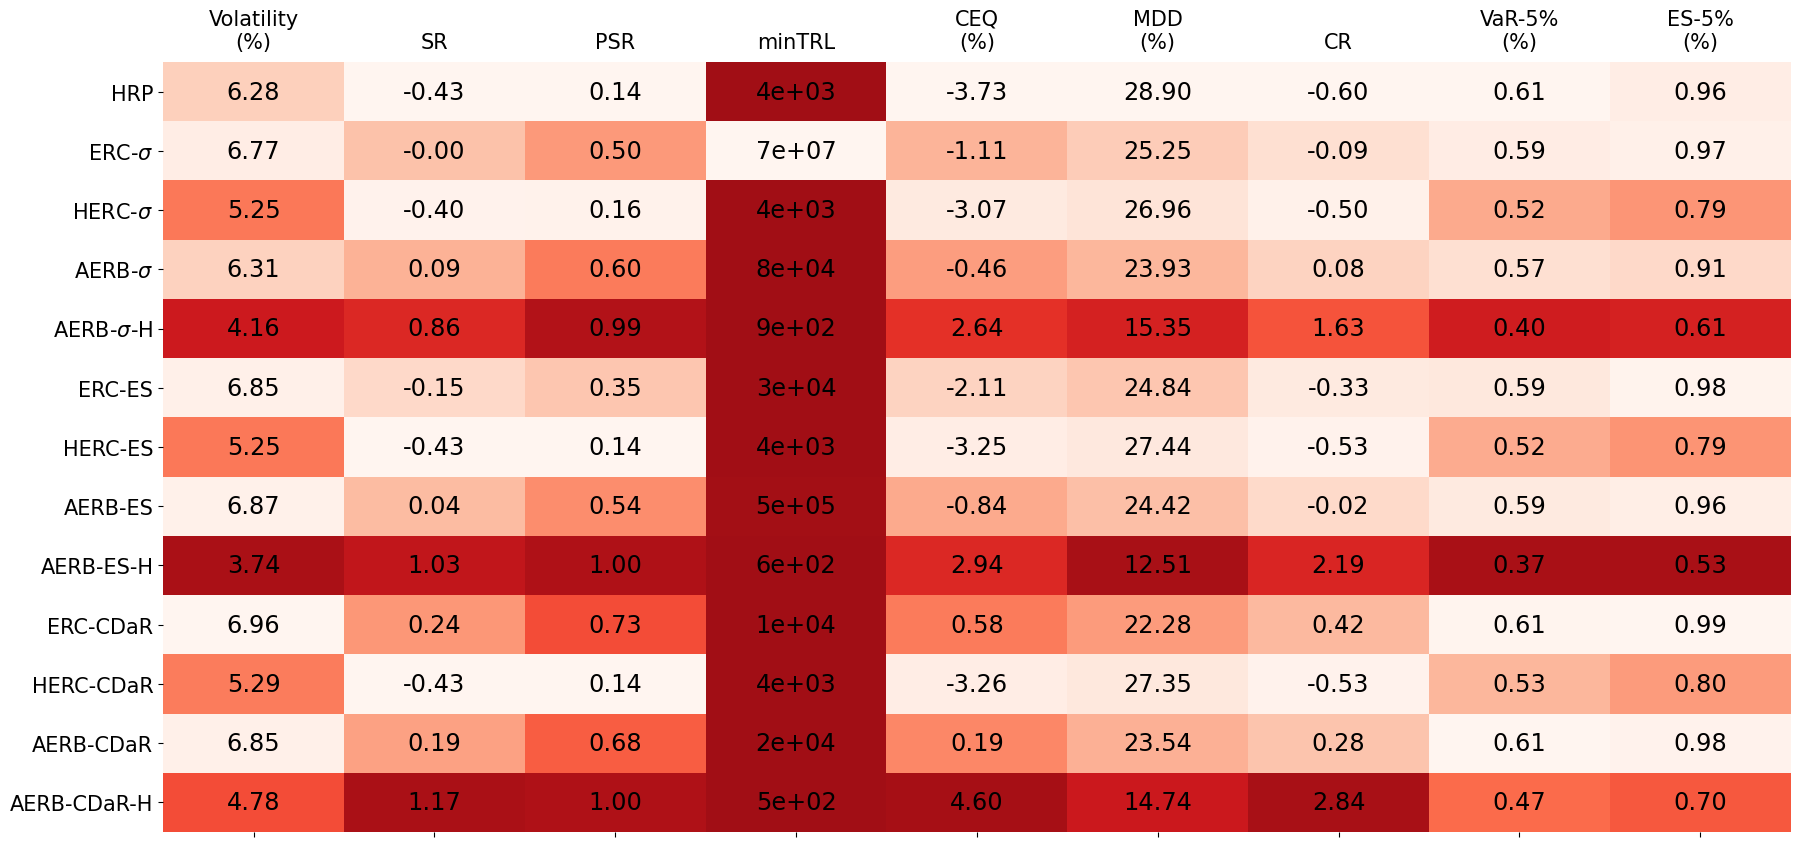

In [6]:
save = SAVE
ORDER = [
      "hrp", "erc", "herc_vol", "rb_factor", "rb_factor_hedge", 
      "erc_es_0.01", "herc_es_0.01", "rb_factor_es_0.01", "rb_factor_es_0.01_hedge", 
      "erc_cdar_0.01", "herc_cdar_0.01", "rb_factor_cdar_0.01", "rb_factor_cdar_0.01_hedge"
]

YTICKLABELS = [
    "HRP",  "ERC-$\\sigma$", "HERC-$\\sigma$", "AERB-$\\sigma$", "AERB-$\\sigma$-H", 
    "ERC-ES", "HERC-ES", "AERB-ES", "AERB-ES-H", 
    "ERC-CDaR", "HERC-CDaR", "AERB-CDaR", "AERB-CDaR-H",
]
METRICS_ORDER = [
 "Volatility", "SR", "PSR", "minTRL", "CEQ", "MDD", "CR", "VaR-5%", "ES-5%"
]
pstats = stats1.loc[ORDER, METRICS_ORDER]

fig, axs = plt.subplots(1, len(METRICS_ORDER), figsize = (21,10))
i = 0
for i, c in enumerate(METRICS_ORDER):
    if c in ['Return', 'VaR-5%', 'ES-5%', 'Volatility', 'MDD', 'CEQ', 'TTO']:
        xticklabel = c + '\n(%)'
    else:
        xticklabel = c
    if c == "MT Bets_F":
        xticklabel = "$\operatorname{MT\ Bets}_F$"
    temp = pstats[[c]] 
    min_ = min(temp[c])
    if min_ < 0:
        center = 0
    else:
        center=min(temp[c]) - np.std(temp[c])
    if c in ['VaR-5%', 'ES-5%', 'Volatility', 'MDD', 'TTO', "minTRL", "SSPW", "Leverage"]:
        cmap = "Reds_r" # "Greens_r"
        vmin= min(temp[c]) - 1/2 * np.std(temp[c])
        vmax = max(temp[c])
        center=vmax
    else:
        cmap = "Reds" # "Greens"
        vmin= min(temp[c])
        vmax= max(temp[c]) + 1/2 * np.std(temp[c])
        
    sns.heatmap(np.abs(temp) if c == "SSPW" else temp,
                cmap=cmap, 
                # center=center,
                vmin=vmin,
                vmax=vmax,
                annot=True,
                fmt='.2f' if c != "minTRL" else '.1g',
                annot_kws={'color': 'black', 'size': 'xx-large', 'ha': 'center'},
                yticklabels = YTICKLABELS,
                xticklabels = [xticklabel],
                cbar=False,
                ax=axs[i])
    
    if i == 0:
        axs[i].tick_params(axis='y', labelrotation = 0, labelsize=15)
    else:
        axs[i].set_yticks([])
        
    axs[i].tick_params(axis='x', labelrotation = 0,  labelsize=15, labeltop=True, labelbottom=False)

plt.subplots_adjust(wspace=0, hspace=0)

if save:
    plt.savefig(f'{savedir}/stats_heatmap_hedge_dataset1.png', bbox_inches='tight', transparent=True)
   
    

# Dataset 2

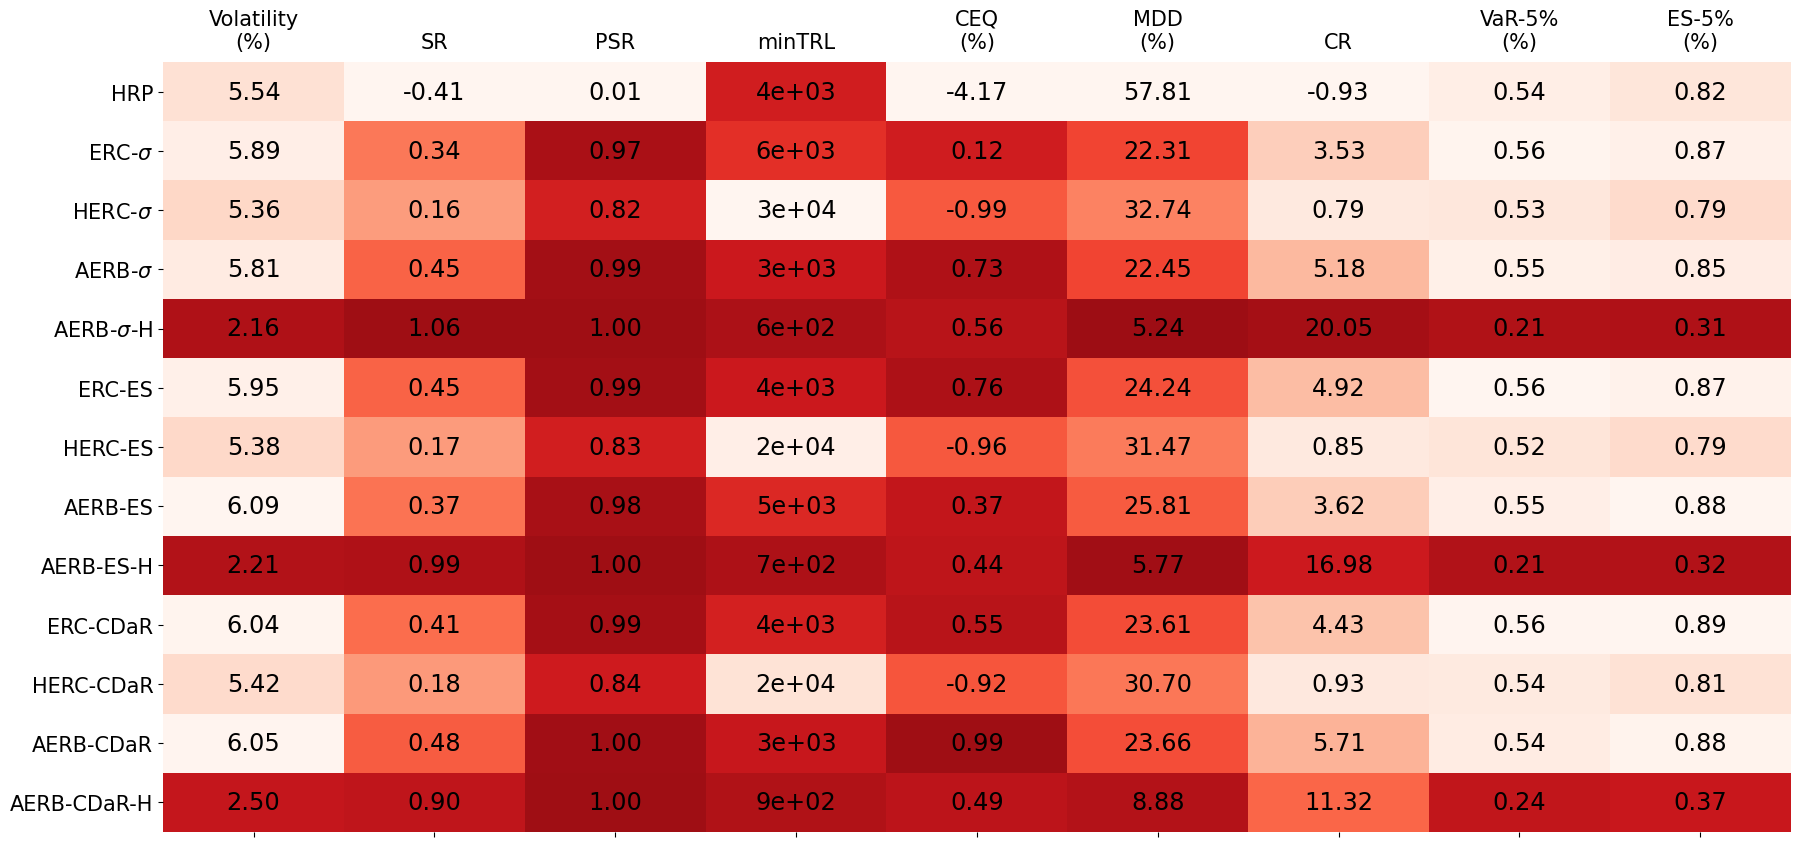

In [7]:
save = SAVE

pstats = stats2.loc[ORDER, METRICS_ORDER]
fig, axs = plt.subplots(1, len(METRICS_ORDER), figsize = (21,10))
i = 0
for i, c in enumerate(METRICS_ORDER):
    if c in ['Return', 'VaR-5%', 'ES-5%', 'Volatility', 'MDD', 'CEQ', 'TTO']:
        xticklabel = c + '\n(%)'
    else:
        xticklabel = c
    if c == "MT Bets_F":
        xticklabel = "$\operatorname{MT\ Bets}_F$"
    temp = pstats[[c]] 
    min_ = min(temp[c])
    if min_ < 0:
        center = 0
    else:
        center=min(temp[c]) - np.std(temp[c])
    if c in ['VaR-5%', 'ES-5%', 'Volatility', 'MDD', 'TTO', "minTRL", "SSPW", "Leverage"]:
        cmap = "Reds_r" # "Greens_r"
        vmin= min(temp[c]) - 1/2 * np.std(temp[c])
        vmax = max(temp[c])
        center=vmax
    else:
        cmap = "Reds" # "Greens"
        vmin= min(temp[c])
        vmax= max(temp[c]) + 1/2 * np.std(temp[c])
        
    sns.heatmap(np.abs(temp) if c == "SSPW" else temp,
                cmap=cmap, 
                # center=center,
                vmin=vmin,
                vmax=vmax,
                annot=True,
                fmt='.2f' if c != "minTRL" else '.1g',
                annot_kws={'color': 'black', 'size': 'xx-large', 'ha': 'center'},
                yticklabels = YTICKLABELS,
                xticklabels = [xticklabel],
                cbar=False,
                ax=axs[i])
    
    if i == 0:
        axs[i].tick_params(axis='y', labelrotation = 0, labelsize=15)
    else:
        axs[i].set_yticks([])
        
    axs[i].tick_params(axis='x', labelrotation = 0,  labelsize=15, labeltop=True, labelbottom=False)

plt.subplots_adjust(wspace=0, hspace=0)

if save:
    plt.savefig(f'{savedir}/stats_heatmap_hedge_dataset2.png', bbox_inches='tight', transparent=True)
   
    

# SPA Test

# First run spa_hedge.py!

## Dataset 1

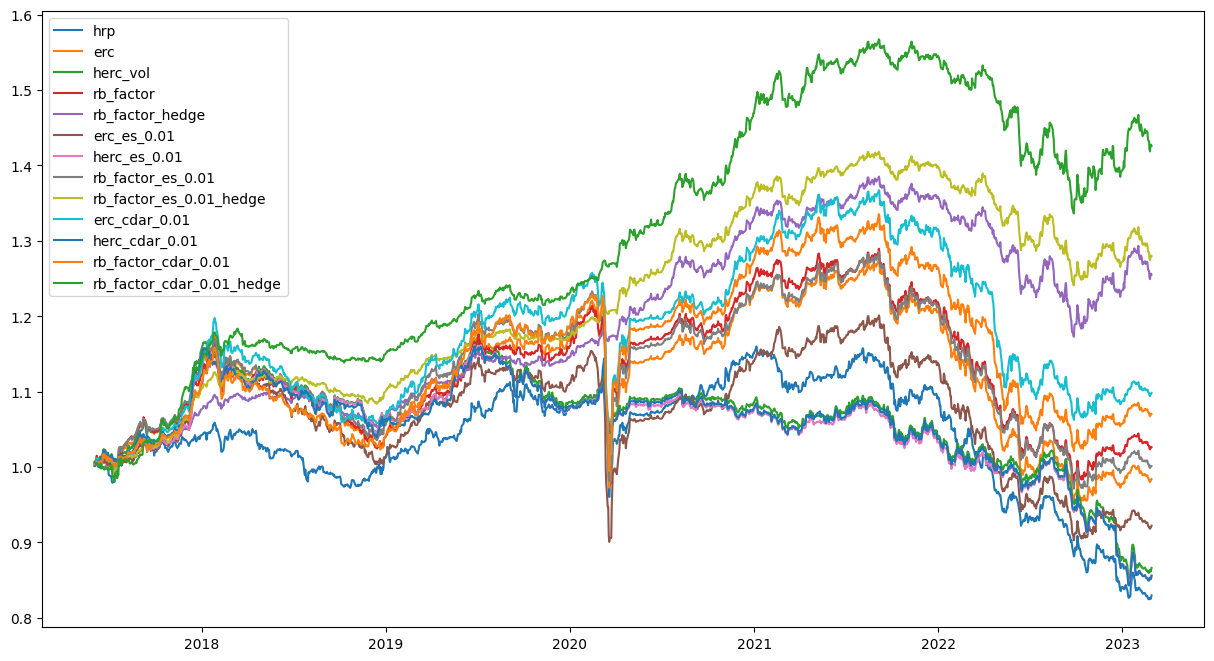

In [8]:
from arch.bootstrap import SPA
from dl_portfolio.reality_check import reality_check

plt.figure(figsize=(15,8))
plt.plot(total_return1[ORDER])
plt.legend(ORDER)
plt.show()

In [9]:
save = SAVE
benchmarks = [
    "rb_factor", "rb_factor_es_0.01", "rb_factor_cdar_0.01"
]
p_values = pd.DataFrame(columns = ["returns", "sr", "mdd"], index = benchmarks)
for col_bench in benchmarks:
    col_test = col_bench + "_hedge"
    print(col_test)
    returns = perf1[[col_bench, col_test]]

    spa = SPA(-returns[col_bench], -returns[col_test], block_size=10, bootstrap="stationary", seed=0)
    spa.compute()
    p_values.loc[col_bench, "returns"] = spa.pvalues["consistent"]
    p_val = reality_check(returns, "sharpe_ratio", col_test=[col_test],
                          col_bench=col_bench, n_b=1000, seed=0)
    p_values.loc[col_bench, "sr"] = p_val
    p_val = reality_check(returns, "mdd", col_test=[col_test],
                          col_bench=col_bench, n_b=1000, seed=0)
    p_values.loc[col_bench, "mdd"] = p_val
    
n = 100
spa_ret = pd.read_pickle(f"{perf_ae_dir_1}/spa_hedge_returns_{n}.p")
for strat in spa_ret:
    col_test = f"{strat}_hedge"
    print(col_test)
    returns = pd.concat([spa_ret[strat], perf1[col_test]], axis=1)
    spa = SPA(-returns[col_test], -returns.drop(col_test, axis=1),
          block_size=10, bootstrap="stationary", seed=0)
    spa.compute()
    p_values.loc[f"random_{strat}", "returns"] = 1 - spa.pvalues["consistent"]
    p_val = reality_check(returns, "sharpe_ratio", col_test=list(range(n)),
                          col_bench=col_test, n_b=1000, seed=0)
    p_values.loc[f"random_{strat}", "sr"] = 1 - p_val
    p_val = reality_check(returns, "mdd", col_test=list(range(n)),
                          col_bench=col_test, n_b=1000, seed=0)
    p_values.loc[f"random_{strat}", "mdd"] = 1 - p_val

p_values.columns = ["$\\operatorname{E}(R_t)$", "SR", "MDD"]
p_values = p_values.astype(float)
p_values

rb_factor_hedge
rb_factor_es_0.01_hedge
rb_factor_cdar_0.01_hedge
rb_factor_hedge
rb_factor_es_0.01_hedge
rb_factor_cdar_0.01_hedge


,$\operatorname{E}(R_t)$,SR,MDD
rb_factor,0.101,0.000,0.017
rb_factor_es_0.01,0.105,0.000,0.000
rb_factor_cdar_0.01,0.071,0.000,0.001
random_rb_factor,0.019,0.000,0.004
random_rb_factor_es_0.01,0.024,0.002,0.120
random_rb_factor_cdar_0.01,0.046,0.005,0.012


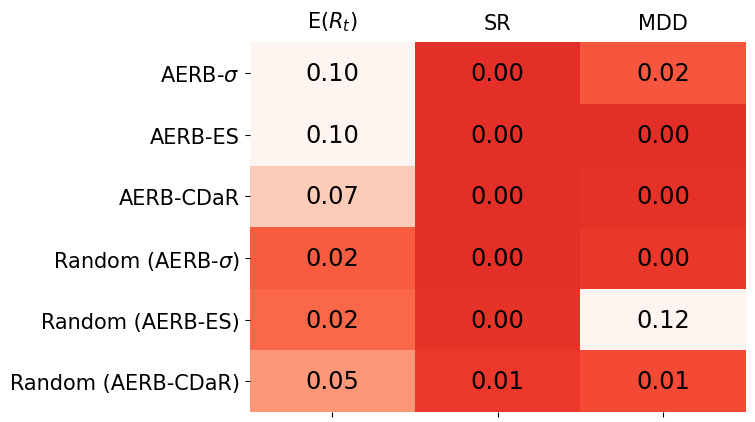

In [10]:
save=SAVE
YTICKLABELS = ["AERB-$\\sigma$", "AERB-ES", "AERB-CDaR", 
               "Random (AERB-$\\sigma$)", "Random (AERB-ES)", "Random (AERB-CDaR)"]
fig, axs = plt.subplots(1, p_values.shape[-1]) # , figsize = (21,10)
i = 0
for i, c in enumerate(p_values.columns):
    temp = p_values[[c]] 
    vmax = 0.1
    vmin = -0.05
    sns.heatmap(temp,
                cmap="Reds_r", 
                vmin=vmin,
                vmax=vmax,
                annot=True,
                fmt='.2f',
                annot_kws={'color': 'black', 'size': 'xx-large', 'ha': 'center'},
                yticklabels = YTICKLABELS,
                xticklabels = [c],
                cbar=False,
                ax=axs[i])
    
    if i == 0:
        axs[i].tick_params(axis='y', labelrotation = 0, labelsize=15)
    else:
        axs[i].set_yticks([])
        
    axs[i].tick_params(axis='x', labelrotation = 0,  labelsize=15, labeltop=True, labelbottom=False)
plt.subplots_adjust(wspace=0, hspace=0)
if save:
    plt.savefig(f'{savedir}/spa_p_values_hedge_dataset1.png', bbox_inches='tight', transparent=True)

# Dataset 2

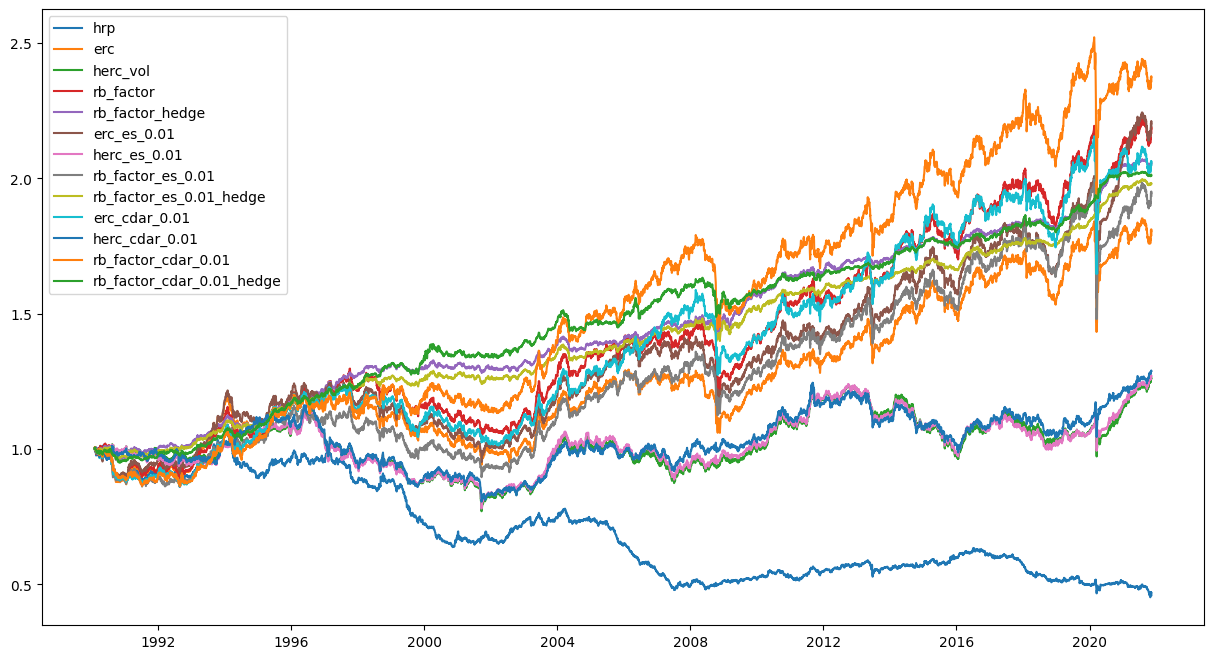

In [11]:
plt.figure(figsize=(15,8))
plt.plot(total_return2[ORDER])
plt.legend(ORDER)
plt.show()

In [12]:
save = SAVE
benchmarks = [
    "rb_factor", "rb_factor_es_0.01", "rb_factor_cdar_0.01"
]
p_values = pd.DataFrame(columns = ["returns", "sr", "mdd"], index = benchmarks)
for col_bench in benchmarks:
    col_test = col_bench + "_hedge"
    print(col_test)
    returns = perf2[[col_bench, col_test]]

    spa = SPA(-returns[col_bench], -returns[col_test], block_size=10, bootstrap="stationary", seed=0)
    spa.compute()
    p_values.loc[col_bench, "returns"] = spa.pvalues["consistent"]
    p_val = reality_check(returns, "sharpe_ratio", col_test=[col_test],
                          col_bench=col_bench, n_b=1000, seed=0)
    p_values.loc[col_bench, "sr"] = p_val
    p_val = reality_check(returns, "mdd", col_test=[col_test],
                          col_bench=col_bench, n_b=1000, seed=0)
    p_values.loc[col_bench, "mdd"] = p_val
    
n = 100
spa_ret = pd.read_pickle(f"{perf_ae_dir_2}/spa_hedge_returns_{n}.p")
for strat in spa_ret:
    col_test = f"{strat}_hedge"
    print(col_test)
    returns = pd.concat([spa_ret[strat], perf2[col_test]], axis=1)
    spa = SPA(-returns[col_test], -returns.drop(col_test, axis=1),
          block_size=10, bootstrap="stationary", seed=0)
    spa.compute()
    p_values.loc[f"random_{strat}", "returns"] = 1 - spa.pvalues["consistent"]
    p_val = reality_check(returns, "sharpe_ratio", col_test=list(range(n)),
                          col_bench=col_test, n_b=1000, seed=0)
    p_values.loc[f"random_{strat}", "sr"] = 1 - p_val
    p_val = reality_check(returns, "mdd", col_test=list(range(n)),
                          col_bench=col_test, n_b=1000, seed=0)
    p_values.loc[f"random_{strat}", "mdd"] = 1 - p_val

p_values.columns = ["$\\operatorname{E}(R_t)$", "SR", "MDD"]
p_values = p_values.astype(float)
p_values

rb_factor_hedge
rb_factor_es_0.01_hedge
rb_factor_cdar_0.01_hedge
rb_factor_hedge
rb_factor_es_0.01_hedge
rb_factor_cdar_0.01_hedge


,$\operatorname{E}(R_t)$,SR,MDD
rb_factor,0.631,0.000,0.022
rb_factor_es_0.01,0.540,0.000,0.003
rb_factor_cdar_0.01,0.771,0.005,0.010
random_rb_factor,0.033,0.004,0.001
random_rb_factor_es_0.01,0.044,0.012,0.001
random_rb_factor_cdar_0.01,0.164,0.015,0.001


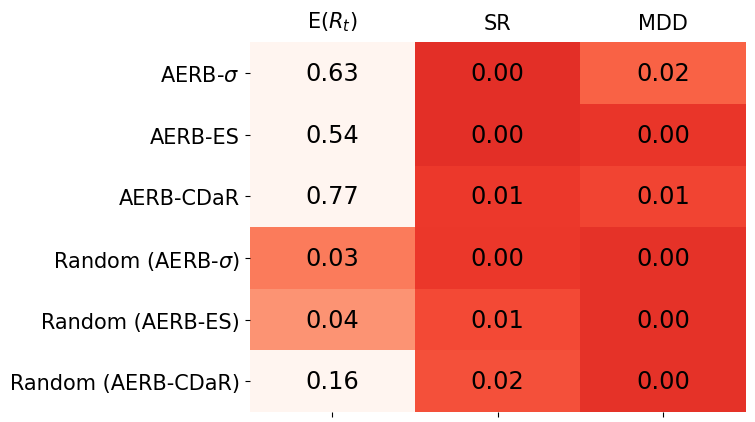

In [13]:
save=SAVE
YTICKLABELS = ["AERB-$\\sigma$", "AERB-ES", "AERB-CDaR", 
               "Random (AERB-$\\sigma$)", "Random (AERB-ES)", "Random (AERB-CDaR)"]
fig, axs = plt.subplots(1, p_values.shape[-1]) # , figsize = (21,10)
i = 0
for i, c in enumerate(p_values.columns):
    temp = p_values[[c]] 
    vmax = 0.1
    vmin = -0.05
    sns.heatmap(temp,
                cmap="Reds_r", 
                vmin=vmin,
                vmax=vmax,
                annot=True,
                fmt='.2f',
                annot_kws={'color': 'black', 'size': 'xx-large', 'ha': 'center'},
                yticklabels = YTICKLABELS,
                xticklabels = [c],
                cbar=False,
                ax=axs[i])
    
    if i == 0:
        axs[i].tick_params(axis='y', labelrotation = 0, labelsize=15)
    else:
        axs[i].set_yticks([])
        
    axs[i].tick_params(axis='x', labelrotation = 0,  labelsize=15, labeltop=True, labelbottom=False)
plt.subplots_adjust(wspace=0, hspace=0)
if save:
    plt.savefig(f'{savedir}/spa_p_values_hedge_dataset2.png', bbox_inches='tight', transparent=True)